In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the functions to be used in calculating iron production cost

In [18]:
# Default Variables
syn_eta = 0.8                # synthesis eff
fe_eta = 0.8                 # faradaic eff
electricity_costs = 0.05     # industrial electricity prices in $/kWh
ore_cost = 100                # in $/ton
hcl_cost = 100               # in $/ton
hcl_mass_ratio = 6
j_cell = 2000                    # A/m^2
Cl2_FE = 0.98
NaOH_FE = 0.95
Fe_Harvest = 700 * 1000 / (365 * 24)        #$/tonFe y-1

# Global variables
F = 96485 # C/mol

In [19]:
## Estimating the capital cost of balance of plant

# --- Mechanical ---
# Chlorine production per day: 1000 A * 3600s/hr * 24h/day / (2e- * 96485 C/mol) = mol/day
# Chlorine production per year: mol / day * 365 day / year * 70.9 g/mol / (1000 g / kg * 1000 kg / tonne)
Cl2_kA_to_tonne = 1 * j_cell * 3600 * 24 / (2 * 96485) * 365 * 70.9 / (1000 * 1000)

# Values converted from Klaucke from 2021 Euro to 2024 dollars (approx. ~1.1)
Cl2_Treatment = 1388 * 1000 / (365 * 24)# $/tonCl2 y–1
NaOH_Storage = 73.7 * 1000 / (365 * 24)# $/tonNaOH y–1
Hydrogen_Treatment = 1921 * 1000 / (365 * 24)# $/tonH2 y–1
Electrolyte_Circ = 107 * 1000 / (365 * 24) # $/tonNaOH y-1 

# --- Electrical ---
# Cost of transformers and rectifiers
Trans_Rect = 0.562 # $/kA

In [ ]:
# Calculate Total Fe Cost for base case
def Fe_Cost (etasy = syn_eta,      # synthesis efficicnecy
             etafe = fe_eta,          # faradaic efficiency
             elec = electricity_costs,         # power cost in $/kWh
             orec = ore_cost,          # cost of 1 tonne of in $
             hclc = hcl_cost,        # cost of HCl in $/tonne
             hclm = hcl_mass_ratio,        # tonnes of HCl used per tonne of Fe
             etaCl2 = Cl2_FE,       # Cl2 faradaic eff
             etaNaOH = NaOH_FE,     # NaOH faradaic eff
             harvest_Fe = Fe_Harvest,
             jtot = j_cell,
             years = 20):         
    
    # Costs of cell construction
    Anode_Cost = 1000 # $/m^2 estimated from purchase price of chlor alkali anodes
    Cathode_Cost = 250 # $/m^2 estimated from cost of 18 GA SS sheets
    Membrane_Cost = 1100 # $/m^2 Hofmann assumes $3000 for a 2.72 m^2 membrane
    Ancillary = 3000 # $/m^2 cell area for frames, busbars, flowfields... 
    Manufacturing = 2 # cell assembly and profit margins
          
    # power cost
    Fe_cost_power = 4300 * elec / etafe #4300 kWh/tonne_Fe multiplied to power cost in $/kWh for 1 ton of Fe

    # cost of ore
    Fe_cost_ore = 1.38 * orec / etasy       # 1 ton of Fe at 100%FE is produced from 1.38 tonnes of Fe3O4
                                            # #cost of ore to produce 1 ton of Fe
    
    # cost of HCl
    Fe_cost_hcl = hclm * hclc             # 4 tonnes fo HCl is required to produce 1 ton of Fe 
                                            # at stochiometric value


    # This will yield 8.2 tonnes of iron considering 2m^2 cathode running at 2000 A/m^2 for 365 days with 0.95 operational efficiency and 0.95 faradaic efficiency

    Fe_Stack_Cost = (Anode_Cost + Cathode_Cost + Membrane_Cost + Ancillary) * Manufacturing / (Manufacturing * jtot * 0.95 * etafe * 8760 * 3600 * years * 55.8 / (1E6 * 8 * 96485) )    
    
    # Cost of harvesting iron is unproven and could be swept as a parameter ($ per kg/hr capacity)
    # We have assumed the cost to lie somewhere in between the cost of processing Cl2 and the cost of processing NaOH
    
    # Function returns the cost per system kA
    # Basis current = 1000 A
  
    # Plant production rates
    H2_FE = 1 - etafe
    Rate_H2 = j_cell * H2_FE / (2 * F) * 2 * 0.95 * 8760 * 3600 / (1E6) # tonnes of H2/ year
    Rate_Cl2 = j_cell * etaCl2 / (2 * F) * 70.9 * 0.95 * 8760 * 3600 / (1E6) # tonnes of Cl2/ year
    Rate_Fe = j_cell * etafe / (8 / 3 * F) * 55.85 * 0.95 * 8760 * 3600 / (1E6) # tonnes of Fe/ year
    Rate_NaOH = j_cell * etaNaOH / (F) * 39.9 * 0.95 * 8760 * 3600 / (1E6) # tonnes of NaoH/ year
    
    # Capital: H2 and Cl2 treatment required for gas products. NaOH treatment and storage. Fe harvesting costs.
    H2_Cost = Hydrogen_Treatment * Rate_H2
    Cl2_Cost = Cl2_Treatment * Rate_Cl2
    NaOH_Cost = (NaOH_Storage + Electrolyte_Circ) * Rate_NaOH
    Fe_Cost = harvest_Fe * Rate_Fe
    
    # Levelize costs of Fe over 20 year plant lifetime
    Fe_BOP_cost = (Fe_Cost + NaOH_Cost + Cl2_Cost + H2_Cost + Trans_Rect) / years # for 20 years
    Fe_Cl2_Revenue = 4 * 70.9 / (3 * 55.84) * etaCl2 / 0.9 * 200

    # Total ASR
    total = Fe_cost_hcl + Fe_cost_power + Fe_cost_ore + Fe_Stack_Cost + Fe_BOP_cost - Fe_Cl2_Revenue
   
    return(total)


In [ ]:
# Set high, low, and base case for each model variable
base = Fe_Cost()

## current density
high_jtot = Fe_Cost(jtot = 300)
base_jtot = Fe_Cost()
low_jtot = Fe_Cost(jtot = 10000)

## Precipitation efficiency
high_etasy = Fe_Cost(etasy = 0.6)
base_etasy = Fe_Cost()
low_etasy = Fe_Cost(etasy = 0.9)

## Faradaic efficiency
high_etafe = Fe_Cost(etafe = 0.60)
base_etafe = Fe_Cost()
low_etafe = Fe_Cost(etafe = 0.95)

## Mass of HCl (tonnes per ton of Fe)
high_hclm = Fe_Cost(hclm = 12) 
base_hclm = Fe_Cost()
low_hclm = Fe_Cost(hclm = 4)

## Cost of power ($)
high_elec = Fe_Cost(elec = 0.09)
base_elec = Fe_Cost()
low_elec = Fe_Cost(elec = 0.02)

## Cost of HCl ($)
high_hclc = Fe_Cost(hclc = 250)
base_hclc = Fe_Cost()
low_hclc = Fe_Cost(hclc = 10)

## Cost of iron oxide ore ($)
high_orec = Fe_Cost(orec = 200)
base_orec = Fe_Cost()
low_orec = Fe_Cost(orec = 10)


<ipython-input-12-7a08634be3b6>:21: RuntimeWarning: divide by zero encountered in double_scalars
  Fe_cost_power = 4300 * elec / etafe #4300 kWh/tonne_Fe multiplied to power cost in $/kWh for 1 ton of Fe
<ipython-input-12-7a08634be3b6>:34: RuntimeWarning: divide by zero encountered in double_scalars
  Fe_Stack_Cost = (Anode_Cost + Cathode_Cost + Membrane_Cost + Ancillary) * Manufacturing / (Manufacturing * jtot * 0.95 * etafe * 8760 * 3600 * years * 55.8 / (1E6 * 8 * 96485) )


(0.0, 3000.0)

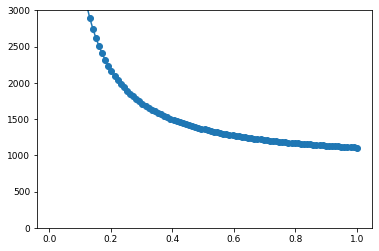

In [ ]:
# Single parameter sensitivity analysis
fig, ax = plt.subplots()

xs = np.linspace(0,1,100)
ys = []
for x in xs:
    ys.append(Fe_Cost(etafe=x))
ax.plot(xs, ys, marker='o')
ax.set_ylim (0, 3000)

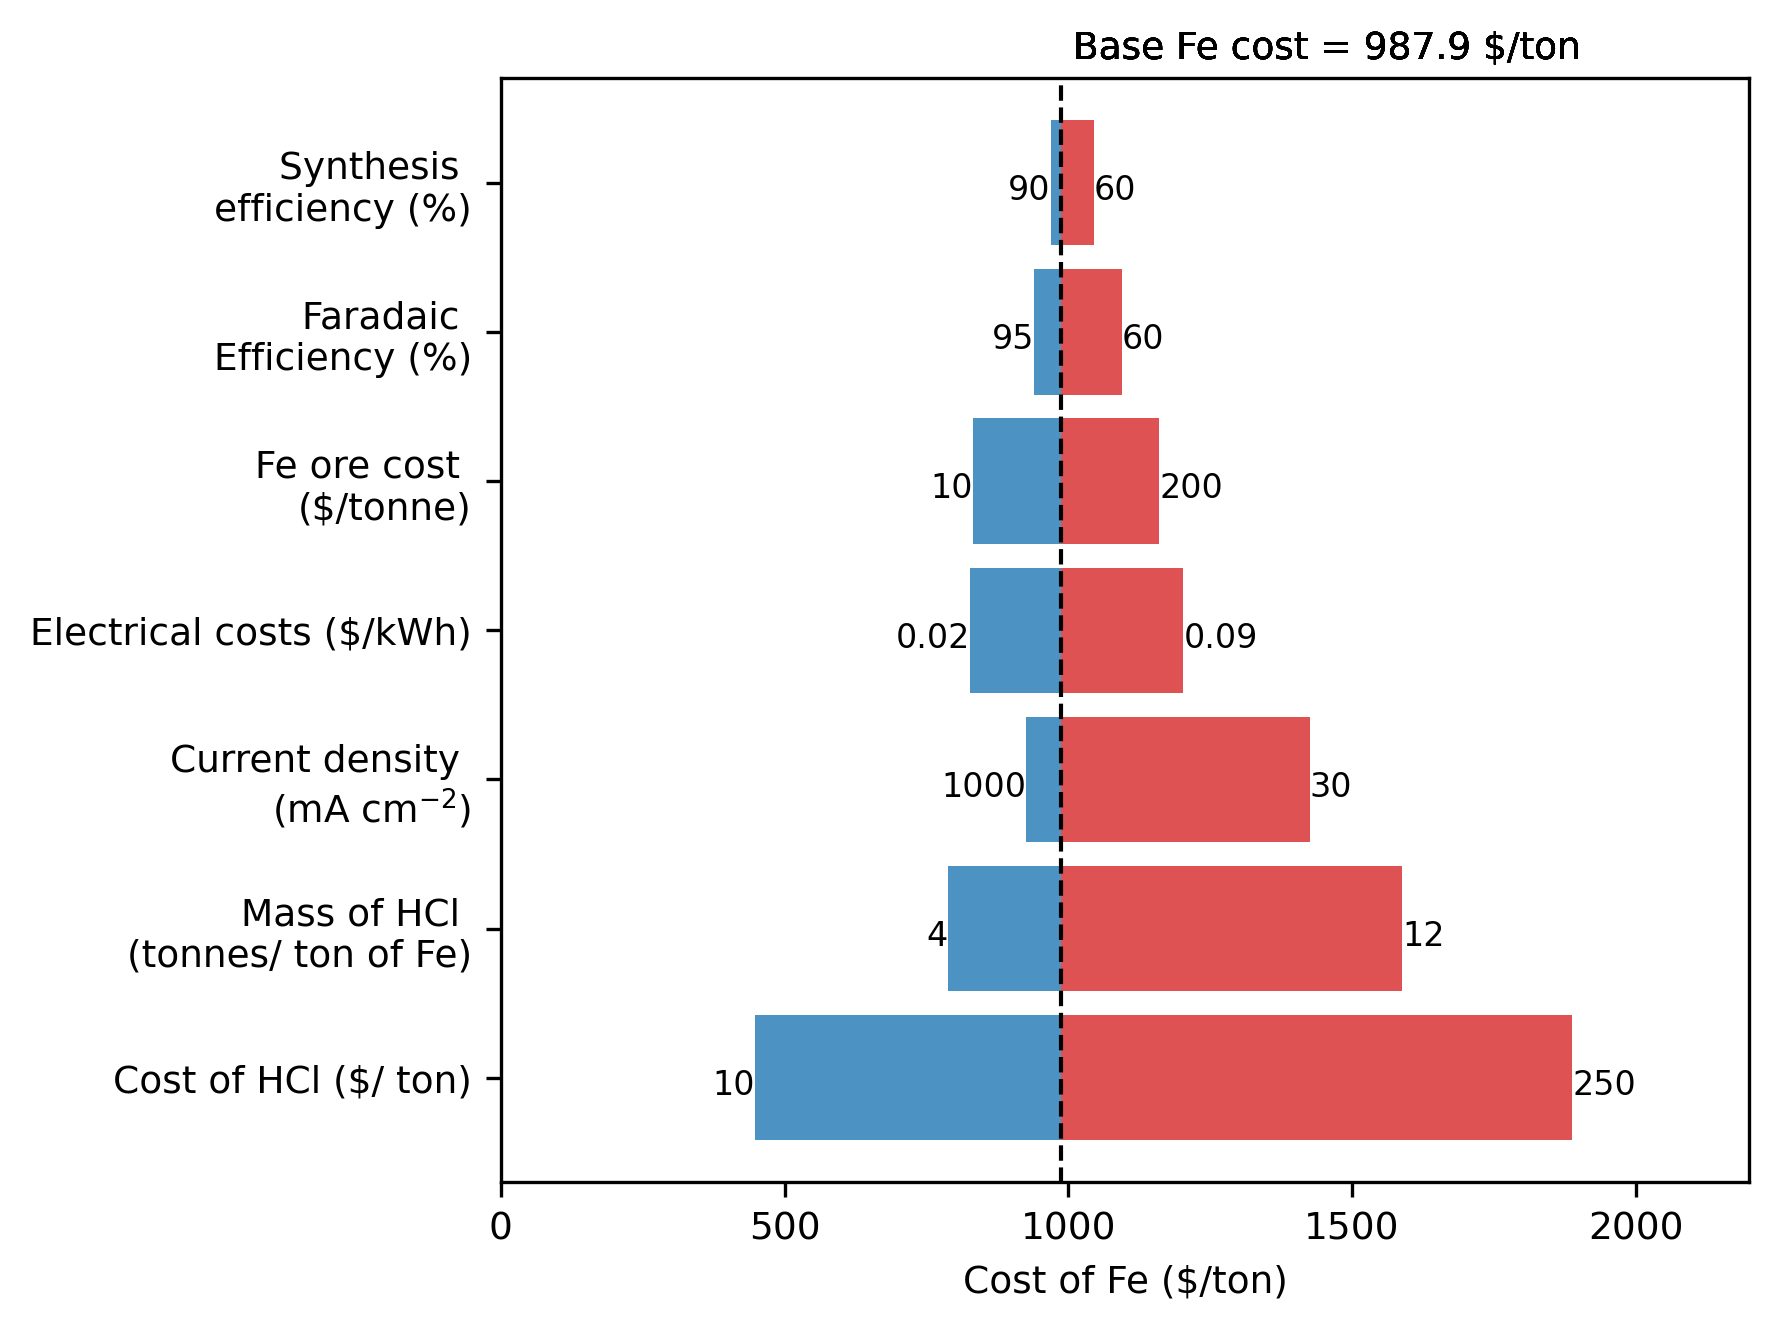

Iron oxide synth = 0.8, Fe ore = 100, electricity costs = 0.05, Faradaic efficiency = 0.8, cell current density = 2000, mass ratio = 6, HCl cost = 100


In [ ]:
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 9}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(6,4.5))
 
# Create bar chart labels
labels = [ 'Cost of HCl ($/ ton)', 'Mass of HCl \n(tonnes/ ton of Fe)', 'Current density \n(mA cm$^{-2}$)', 'Electrical costs ($/kWh)', 'Fe ore cost \n($/tonne)', 'Faradaic \nEfficiency (%)', 'Synthesis \nefficiency (%)']

compression=1.4
xs = [(x+1)/compression for x in range(0,len(labels))]

# Create lists of high, low, and base case values for each parameter
highs = [high_hclc, high_hclm, high_jtot, high_elec, high_orec, high_etafe, high_etasy]
meds = [base_hclc, base_hclm, base_jtot, base_elec, base_orec, base_etafe, base_etasy]
lows = [low_hclc, low_hclm, low_jtot, low_elec, low_orec, low_etafe, low_etasy]

# Add labels to the bar chart
lowlabels=['10','4', '1000', '0.02', '10', '95', '90']
highlabels=['250', '12', '30', '0.09', '200','60', '60']

AVAL = 0.8
heights = 0.6

for pos, x in enumerate(xs):   
    plt.broken_barh([(Fe_Cost(), highs[pos] - Fe_Cost())],
                (x - heights/2, heights),
                facecolors="tab:red",
                alpha=AVAL)

    plt.broken_barh([(lows[pos], Fe_Cost() - lows[pos])],
                (x - heights/2, heights),
                facecolors="tab:blue",
                alpha=AVAL)
    
    plt.text(highs[pos]+0.2, x-0.08, highlabels[pos], size=8)
    plt.text(lows[pos]-0.2, x-0.08, lowlabels[pos], horizontalalignment='right', size=8)

    base_cost = Fe_Cost()
    plt.text(base_cost + 20, xs[-1] + 0.6,
         f"Base Fe cost = {base_cost:.1f} $/ton",
         fontsize=9, color='black')
         
plt.plot([Fe_Cost(), Fe_Cost()],[0, 10],'k--',linewidth=1)

    
ax.set_yticks(xs)
ax.set_xticks([0, 500, 1000, 1500, 2000])
ax.set_yticklabels(labels,rotation=0)
ax.set_xlabel('Cost of Fe ($/ton)')

ax.set_ylim([xs[0]-0.5,xs[-1]+0.5])
ax.set_xlim([0,2200])

plt.gcf().set_dpi(300)
fig.tight_layout()

#fig.savefig('Fe_cost_sensitivity_plot.png')
#plt.savefig('Fe_cost_sensitivity_plot.eps', format = 'eps')
plt.show()

print("Iron oxide synth = {}, Fe ore = {}, electricity costs = {}, Faradaic efficiency = {}, cell current density = {}, mass ratio = {}, HCl cost = {}".format(
        syn_eta, ore_cost, electricity_costs, fe_eta, j_cell, hcl_mass_ratio, hcl_cost))

In [36]:
# China case study
# HCl = $15/ton and power cost = $50/MWh

print("China case study Fe cost: $", Fe_Cost(hclc=15, elec =0.044))

# US case study
# HCl = $230/ton and power cost = $70/MWh

print("US case study Fe cost: $", Fe_Cost(hclc=230, elec=0.0847))

# Norway case study
# HCl = $130/ton and power cost = $42/MWh*1.16 to USD

print("Norway case study Fe cost: $", Fe_Cost(hclc=130, elec=0.0456*1.16))

# Brazil case study
# HCl = $230/ton and power cost = $30/MWh

print("Brazil case study Fe cost: $", Fe_Cost(hclc=230, elec=0.03))


China case study Fe cost: $ 445.67517403728266
US case study Fe cost: $ 1954.4376740372822
Norway case study Fe cost: $ 1183.4911740372827
Brazil case study Fe cost: $ 1660.4251740372827
